In [ ]:
import torch
import torch.nn as nn

import matplotlib.pyplot as plt
import numpy as np
import time

import shutil

import pandas as pd
from scipy.io import loadmat
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import torch.nn.functional as F
import copy
import scipy.io
from sklearn.metrics import r2_score
import time
#from pytorch_tcn import TCN
np.random.seed(1917)
torch.manual_seed(1917)
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error

# Best modelfor 1500-2500 used here is model_LSTM_Tempo_Salinity_AC_interpol.pth.tar.pth.tar with 77 hidden layers 0.65 lr_edcay, epoch>24 regularization 1e-8 lr0:0.9e-3
# Best model for 1500-2500 used for validation 2500-2800 is model_LSTM_Tempo_Salinity_AC_interpol_(1500-3000)_latest.pth.tar(yes it is 3000!! where the results are only upto 2500) hidden_size:77, le0:0.6e-3,lr_decay:0.67,weight_Decay:1e-6,epoch>23
# Best model for 1500-3000 with validation 3000-3300 is model_LSTM_Tempo_Salinity_AC_interpol_(1500-3000).pth.tar(Yes got overidden from previous case(1500-2500)) hidden layer=77; num layers=1; lr0:0.5e-3 ; lr_decay:0.8; epoch>20 ; no weight decay

# Best model for 1500-7500  id model_LSTM_Tempo_Salinity_AC_interpol_(1500-3000)_(7500-8500).pth.tar  hidden_size:77;lr0:0.4e-3; lr_decay:0.80;weight_decay:1e-7;epoch>20



In [ ]:
encoded_size=3
BC_cond=3
time_Step=10
time_step=10

## Define Hyperparameters for training GRU+FC

In [ ]:
LSTM_parameters={'input_size':encoded_size+BC_cond,'hidden_size':77,
              'num_layers': 1,
              'output_size': encoded_size*time_Step}

trainer_info={'epochs': 250,
                'train_size': 6501,
                'train_batch': 16,
                'test_batch': 4096,
                'lr0': 0.4e-3,
                'lr_decay': 0.80}

'''LSTM_parameters={'input_size':9,'hidden_size':60,
              'num_layers': 2,
              'output_size': 3}

trainer_info={'epochs': 600,
                'train_size': 6501,
                'train_batch': 16,
                'test_batch': 4096,
                'lr0': 1e-3,
                'lr_decay': 0.60}'''

print_freq=400
device = torch.device('cuda')
note = 'LSTM_DNN'
model_name = 'model' + '_' + str(trainer_info['train_size']) + 'train_' + str(LSTM_parameters['num_layers']) + 'layer_' + str(LSTM_parameters['hidden_size']) + 'hid_' + str(trainer_info['epochs']) + 'ep_' + note


## Define Class

In [ ]:
class LSTM(nn.Module):
    def __init__(self,LSTM_parameters):
        super().__init__()

        input_size = LSTM_parameters['input_size']
        self.hidden_size = LSTM_parameters['hidden_size']
        self.num_layers = LSTM_parameters['num_layers']
        output_size = LSTM_parameters['output_size']

        self.leakrelu = torch.nn.LeakyReLU(negative_slope=0.01)
        
        self.tanh=torch.nn.Tanh()

        self.lstm1 = torch.nn.GRU(input_size, self.hidden_size, self.num_layers, batch_first=True)
    

        self.fc1 = torch.nn.Linear(self.hidden_size, output_size)

    def forward(self,x):

        a0=torch.zeros(self.num_layers,x.shape[0],self.hidden_size).to(device)

        c0=torch.zeros(self.num_layers,x.shape[0],self.hidden_size).to(device)

        #out,(a,c)=self.lstm1(x,(a0,c0))
        
        out,a=self.lstm1(x,a0)
        
        #out=self.leakrelu(out)
        out = self.fc1(out)
        #out = self.leakrelu(out)

        return out
    
class DNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1=torch.nn.Linear(in_features=encoded_size*time_Step,out_features=40,bias=True)
        self.fc2=torch.nn.Linear(in_features=40,out_features=80,bias=True)
        self.fc3=torch.nn.Linear(in_features=80, out_features=160,bias=True)
        self.fc4=torch.nn.Linear(in_features=160, out_features=encoded_size,bias=True)
        '''self.fc5=torch.nn.Linear(in_features=320, out_features=640,bias=True)
        self.fc6=torch.nn.Linear(in_features=640, out_features=4,bias=True)'''
        self.actfunc=torch.nn.LeakyReLU(negative_slope=0.01)

    def forward(self,x):
     
        z1=self.fc1(x)
        a1=self.actfunc(z1)
 
        z2=self.fc2(a1)
        a2=self.actfunc(z2)
     

        z3=self.fc3(a2)
        a3=self.actfunc(z3)


        z4=self.fc4(a3)
        a4=self.actfunc(z4)
        '''z5=self.fc5(a4)
        a5=self.actfunc(z5)


        z6=self.fc6(a5)
        a6=self.actfunc(z6)'''
        
        return a4

class LSTMDNN(nn.Module):
    def __init__(self,LSTM_parameters):
        super().__init__()
        self.lstm=LSTM(LSTM_parameters)
        #self.dnn=DNN()

    def init_weights(self):
        with torch.set_grad_enabled(True):
            
            for name, param in self.named_parameters():
                print(f"Initializing parameter '{name}' with shape: {param.shape}")
                if 'weight' in name:
                    # Use one of the initialization methods
                    #nn.init.xavier_uniform_(param)
                    # nn.init.xavier_normal_(param)
                    # nn.init.kaiming_uniform_(param, nonlinearity='relu')
                     #nn.init.kaiming_normal_(param, nonlinearity='relu')
                    # nn.init.uniform_(param, a=-0.1, b=0.1)
                     #nn.init.normal_(param, mean=0.0, std=0.02)
                    nn.init.orthogonal_(param)
                    # nn.init.sparse_(param, sparsity=0.1)
                elif 'bias' in name:
                    nn.init.constant_(param, 0.0)

    def forward(self,x):
        out=self.lstm(x)

        #pred=self.dnn(out[:,out.shape[1]-1,:])
        return out[:,out.shape[1]-1,:]

## Define Utility and training function

In [ ]:
class AverageMeter(object):
    # Computes and stores the average and current value

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0.     # value
        self.avg = 0.     # averaged value
        self.sum = 0.
        self.count = 0.   # total number of values

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

class MyDataset(torch.utils.data.Dataset):

    def __init__(self, inp, out):
        super().__init__()
        self.inp = inp
        self.out = out

    # This method overloads the built-in function len()
    def __len__(self):
        return self.inp.shape[0]

    # This method overloads the subscription operator '[]', when the object
    # is subscripted like X_train[], the system returns a tuple of objects.
    def __getitem__(self, index):
        return self.inp[index,:], self.out[index,:]
    
class MyDataset1(torch.utils.data.Dataset):

    def __init__(self, inp):
        super().__init__()
        self.inp = inp

    # This method overloads the built-in function len()
    def __len__(self):
        return self.inp.shape[0]

    # This method overloads the subscription operator '[]', when the object
    # is subscripted like X_train[], the system returns a tuple of objects.
    def __getitem__(self, index):
        return self.inp[index,:]

In [ ]:
def train_step(train_loader, model,Ti_Train_set, criterion, optimizer, epoch, net_info):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()

    # switch to train mode
    model.train()

    end = time.time()
    for i, ((input, target),time_stamps) in enumerate(zip((train_loader),Ti_Train_set)):
        # measure data loading time
        data_time.update(time.time() - end)

        input = input.to(device)
        target = target.to(device)
        #time_stamps=time_stamps.to(device)

        # compute output
        output= model(input)#,time_stamps)
    
        loss = criterion(output, target)
        
        #print(enc)
        # measure accuracy and record loss
        losses.update(loss.item(), input.size(0))

        # compute gradient and do the SGD step
        optimizer.zero_grad()
        loss.backward()
        
        '''for name, param in model.named_parameters():
            if param.grad is not None:
                print(f"Gradient for parameter '{name}':\n{param.grad}")
            else:
                print(f"No gradient for parameter '{name}'")'''

        # torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if epoch % 25 == 0:
            if i % print_freq == 0:
                curr_lr = optimizer.param_groups[0]['lr']
                print('Epoch: [{0}/{1}][{2}/{3}]\t'
                    'LR: {4}\t'
                    'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                    'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                    'Loss {loss.val:.7f} ({loss.avg:.6f})\t'.format(
                    epoch, net_info['epochs'], i, len(train_loader), curr_lr,
                    batch_time=batch_time, data_time=data_time, loss=losses))
    return losses.avg


def test_step(test_loader, model,Ti_Val_set, criterion, epoch):
    batch_time = AverageMeter()
    losses = AverageMeter()
    # violation = AverageMeter()

    # switch to evaluate mode
    model.eval()

    end = time.time()
    for i, ((input, target),time_stamps) in enumerate(zip((test_loader),Ti_Val_set)):

        input = input.to(device)
        target = target.to(device)
        #time_stamps=time_stamps.to(device)

        # compute output
        output = model(input)#,time_stamps)
        loss = criterion(output, target)

        # measure accuracy and record loss
        losses.update(loss.item(), input.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if epoch % 25 == 0:
            if i % print_freq == 0:
                print('Test: [{0}/{1}]\t'
                    'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                    'Loss {loss.val:.7f} ({loss.avg:.4f})\t'.format(
                    i, len(test_loader), batch_time=batch_time, loss=losses))
    return losses.avg

#@title train_RNN()
def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    torch.save(state, filename)
    #if is_best:
        #shutil.copyfile(filename, 'model_LSTM_Tempo_Salinity_AC_interpol_(1500-3000)_(7500-8500).pth.tar')
        #shutil.copyfile(filename, 'Salinity_Tempo_AC(1500-3000)')

In [ ]:
def train_LSTM_DNN(model, net_info, train_loader, test_loader,Time_train_loader,Time_test_loader,LSTM_parameters):

    epochs = net_info['epochs']
    train_losses = np.empty([epochs, 1])
    test_losses = np.empty([epochs, 1])

    min_loss = 1e4

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=net_info['lr0'],weight_decay=1e-7)

    for epoch in range(epochs):
        # adjust learning rate
        if epoch >= 20:
            if epoch % 20== 0:
                for param_group in optimizer.param_groups:
                    param_group['lr'] *= net_info['lr_decay']

        # train for one epoch
        train_losses_temp = train_step(train_loader, model,Time_train_loader, criterion, optimizer, epoch, net_info)
        train_losses[epoch] = train_losses_temp

        # evaluate on test set
        test_losses_temp = test_step(test_loader, model,Time_test_loader, criterion, epoch)
        test_losses[epoch] = test_losses_temp

        # remember best MSE and save checkpoint
        is_best = test_losses[epoch] < min_loss
        min_loss = min(test_losses[epoch], min_loss)
        save_checkpoint({
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'min_loss': min_loss,
            'optimizer': optimizer.state_dict(),
        }, is_best)

    test_losses.tofile('test_loss' + str(net_info['train_size']) + '2l50h.csv', sep=",", format="%10.5f")
    train_losses.tofile('train_loss' + str(net_info['train_size']) + '2l50h.csv', sep=",", format="%10.5f")

    plt.figure(figsize=(10, 7))
    plt.plot(train_losses, label='training')
    plt.plot(test_losses, '--', label='test')
    plt.xlabel('epoch')
    plt.ylabel('MSE')
    plt.title('Training and Test Loss\n(hidden size=%s, num layers=%s model'%(LSTM_parameters['hidden_size'],LSTM_parameters['num_layers']))
    plt.yscale('log')
    plt.legend()
    plt.show()
    return model

In [ ]:
def main_program(T_S, T_S_out,val_T_S, val_T_S_out,TT,TV,LSTM_parameters, model,trainer_info, model_name):
    num_sample = trainer_info['train_size']
    T_S_train = T_S[:, :, :]
    T_S_out_train = T_S_out[:, :]
    training_set = MyDataset(T_S_train, T_S_out_train)

    T_S_test = val_T_S[:, :, :]
    T_S_out_test = val_T_S_out[:, :]
    val_set = MyDataset(T_S_test, T_S_out_test)
    
    Ti_Train_set= MyDataset1(TT)
    Ti_Val_set=MyDataset1(TV)

    # create training/test loaders
    train_loader = torch.utils.data.DataLoader(dataset=training_set,
                                               batch_size=trainer_info['train_batch'],
                                               shuffle=True)

    test_loader = torch.utils.data.DataLoader(dataset=val_set,
                                              batch_size=trainer_info['test_batch'],
                                              shuffle=True)
    
    Time_train_loader = torch.utils.data.DataLoader(dataset=Ti_Train_set,
                                               batch_size=trainer_info['train_batch'],
                                               shuffle=True)

    Time_test_loader = torch.utils.data.DataLoader(dataset=Ti_Val_set,
                                              batch_size=trainer_info['test_batch'],
                                              shuffle=True)

    model = train_LSTM_DNN(model, trainer_info, train_loader, test_loader,Time_train_loader,Time_test_loader,LSTM_parameters)
    torch.save(model.state_dict(), model_name)

    return model

## Load the data for training the model

In [ ]:
In=loadmat("TrainingIn")
TrainIn=In['red_train'].astype(np.float32)
Out=loadmat("TrainingOut")
TrainOut=Out['red_train'].astype(np.float32)


In=loadmat("Validation_In")
ValIn=In['val_train'].astype(np.float32)
Out=loadmat("Validation_Out")
ValOut=Out['val_train'].astype(np.float32)

In=loadmat("Test_In")
TestIn=In['red_test'].astype(np.float32)
Out=loadmat("Test_Out")
TestOut=Out['red_test'].astype(np.float32)

time=loadmat("Input_BC")
time=time['BC'].astype(np.float32)[:,0]

hours=time/(3600)


In [ ]:
import time
start_time = time.time() 
model=LSTMDNN(LSTM_parameters).to(device)
#model=TCNN(LSTM_parameters).to(device)
'''model=TimeLSTM(LSTM_parameters).to(device)
model.load_state_dict(torch.load('model_LSTM_Tempo_Salinity_AC.pth.tar.pth.tar')['state_dict'])'''
model = main_program(TrainIn, TrainOut,ValIn,ValOut,Time_Train,Time_Val,LSTM_parameters,model, trainer_info, model_name)
end_time = time.time()
# Calculate and print the total execution time
total_execution_time = end_time - start_time
print(f"Total execution time: {total_execution_time} seconds")

## Load the trained data and the model

In [ ]:
# Added final break phase data to the training set to improve on the predictions for the entire break phase
best_model_params = torch.load('model_LSTM_Tempo_Salinity_AC_interpol_(1500-3000)_(7500-8500).pth.tar', map_location=device)['state_dict']

In [ ]:
model=LSTMDNN(LSTM_parameters).to(device)
model.load_state_dict(best_model_params)

In [ ]:
time_step=10

In [ ]:
Val=loadmat('Val_Inital.mat')
Val_init=Val['Val']
BC_val=loadmat('BC_val.mat')

BCval=BC_val['BC_val']
print(BC_val['BC_val'].shape)
Val_init=torch.from_numpy(Val_init).float().to(device)

BCval=torch.from_numpy(BCval).float().to(device)

print(BCval.shape)

In [ ]:
Test=loadmat('Test_Inital.mat')
Test_init=Test['Test']


In=loadmat("Time_Test")
Time_Test=In['red_test'].astype(np.float32)

BC_test=loadmat('BC_test.mat')
BC=BC_test['BC_test'][time_step:]


print(BC_test['BC_test'].shape)
Test_init=torch.from_numpy(Test_init).float().to(device)
#Time_Test=torch.from_numpy(Time_Test).float().to(device)

BC=torch.from_numpy(BC).float().to(device)

print(BC.shape)


In [ ]:
print(Test_init[0:].shape)

In [ ]:
## For multiple output validation(3000-3300)
predictions_val=torch.zeros([int(300/time_Step),encoded_size*time_step])
p=0
for i in range(int(300/time_Step)):

    predictions_val[i,:]=model(Val_init)
    Val_init[:,:,0:encoded_size]=predictions_val[i,:].reshape(1,time_step,encoded_size)
    Val_init[0,:,encoded_size:]=BCval[p:p+time_step,:]
    p=p+time_step
    
predictionval=torch.zeros([300,encoded_size])
k=0
for i in range(int(300/time_Step)):
    l=0
    for j in range(time_Step):
        predictionval[k,:]=predictions_val[i,l:l+3]
        k=k+1
        l=l+3

In [ ]:
## For multiple output (1500-3000) also from 1500-8000
total=6000
predictions=torch.zeros([int(total/time_Step),encoded_size*time_step])
p=0
for i in range(int(total/time_Step)):
    #print(Test_init)
    predictions[i,:]=model(Test_init)
    Test_init[:,:,0:encoded_size]=predictions[i,:].reshape(1,time_step,encoded_size)
    Test_init[0,:,encoded_size:]=BC[p:p+time_step,:]
    p=p+time_step
    
prediction=torch.zeros([total,encoded_size])
k=0
for i in range(int(total/time_Step)):
    l=0
    for j in range(time_Step):
        prediction[k,:]=predictions[i,l:l+encoded_size]
        k=k+1
        l=l+encoded_size

In [ ]:
filename='predictions_encodings.mat'
predictions_enc={'pred':prediction.cpu().detach().numpy()}
scipy.io.savemat(filename,predictions_enc)

print(prediction.shape)


## Validate on validation set

In [ ]:
Val=loadmat('Val_Set.mat')
Val_encodings_actual=Val['Val_Set']

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
Start=0
End=300
stride=1
days=hours/24

ax[0].plot(days[Start+3000:End+3000],Val_encodings_actual[Start:End:stride, 0],label='Actual')
ax[0].plot(days[Start+3000:End+3000],predictionval.cpu().detach().numpy()[Start:End:stride, 0],label='Predicted')
ax[0].set_xlabel('Time in days')
ax[0].set_ylabel('Latent 1')

ax[1].plot(days[Start+3000:End+3000],Val_encodings_actual[Start:End:stride, 1],label='Actual')
ax[1].plot(days[Start+3000:End+3000],predictionval.cpu().detach().numpy()[Start:End:stride, 1],label='Predicted')
ax[1].set_xlabel('Time in days')
ax[1].set_ylabel('Latent 2')

ax[2].plot(days[Start+3000:End+3000],Val_encodings_actual[Start:End:stride, 2],label='Actual')
ax[2].plot(days[Start+3000:End+3000],predictionval.cpu().detach().numpy()[Start:End:stride, 2],label='Predicted')
ax[2].set_xlabel('Time in days')
ax[2].set_ylabel('Latent 3')

ax[0].legend()
ax[1].legend()
ax[2].legend()

plt.suptitle('Comparison of evolution of two Latent space variables between True and Predicted',fontsize=20)



# Results from Testing

In [ ]:
Test=loadmat('Test_Set.mat')
Test_encodings_actual=Test['Test_Set']

In [26]:
print(prediction)
print(prediction.shape)

filename6='Test_actual_predicted_encodings.mat'
test={'Actual':Test_encodings_actual,'Predicted':prediction.cpu().detach().numpy()}

scipy.io.savemat(filename6,test)


tensor([[-1.9654,  2.5169, -1.4120],
        [-1.9650,  2.5169, -1.4134],
        [-1.9648,  2.5168, -1.4122],
        ...,
        [-2.5670,  1.8738, -1.4042],
        [-2.5673,  1.8723, -1.4021],
        [-2.5686,  1.8707, -1.4044]], grad_fn=<CopySlices>)
torch.Size([6000, 3])


Text(0.5, 0.98, 'Comparison of evolution of three Latent space variables between True and Predicted')

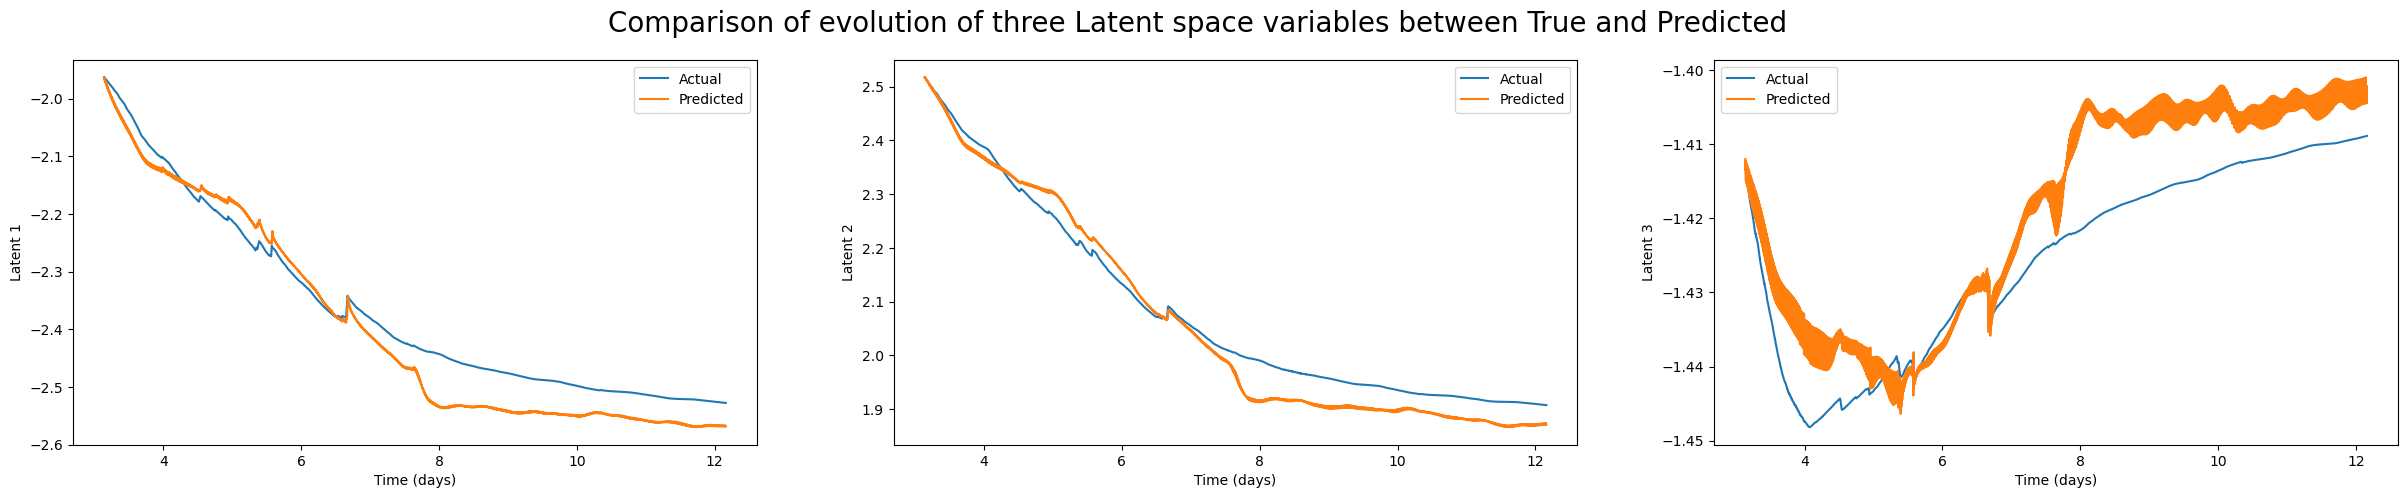

In [29]:
fig, ax = plt.subplots(1, 3, figsize=(30, 5))
Start=0
End=6000
stride=1
days=hours/24

Starts=Start+1500
Ends=End+1500

Startss=0
Endss=6000
ax[0].plot(days[Starts:Ends],Test_encodings_actual[Start:End:stride, 0],label='Actual')
ax[0].plot(days[Starts:Ends],prediction.cpu().detach().numpy()[Start:End:stride, 0],label='Predicted')
ax[0].set_xlabel('Time (days)')
ax[0].set_ylabel('Latent 1')

ax[1].plot(days[Starts:Ends],Test_encodings_actual[Start:End:stride, 1],label='Actual')
ax[1].plot(days[Starts:Ends],prediction.cpu().detach().numpy()[Start:End:stride, 1],label='Predicted')
ax[1].set_xlabel('Time (days)')
ax[1].set_ylabel('Latent 2')

ax[2].plot(days[Starts:Ends],Test_encodings_actual[Start:End:stride, 2],label='Actual')
ax[2].plot(days[Starts:Ends],prediction.cpu().detach().numpy()[Start:End:stride, 2],label='Predicted')
ax[2].set_xlabel('Time (days)')
ax[2].set_ylabel('Latent 3')

'''ax[3].plot(days[Starts:Ends],Test_encodings_actual[Start:End:stride, 3],label='Actual')
ax[3].plot(days[Starts:Ends],prediction.cpu().detach().numpy()[Start:End:stride, 3],label='Predicted')
ax[3].set_xlabel('Time in days')
ax[3].set_ylabel('Latent 3')

ax[4].plot(days[Starts:Ends],Test_encodings_actual[Start:End:stride, 4],label='Actual')
ax[4].plot(days[Starts:Ends],prediction.cpu().detach().numpy()[Start:End:stride, 4],label='Predicted')
ax[4].set_xlabel('Time in days')
ax[4].set_ylabel('Latent 3')
'''
ax[0].legend()
ax[1].legend()
ax[2].legend()
'''ax[3].legend()
ax[4].legend()'''

plt.suptitle('Comparison of evolution of three Latent space variables between True and Predicted',fontsize=20)



In [32]:
red_al=loadmat('reduced_all.mat')
red_al=red_al['red_all']

In [37]:
fig, ax = plt.subplots(1, 3, figsize=(20,10))
Start=0
End=6000
stride=1
days=hours/24

Final=8500


ax[0].plot(days[:Final],red_al[:, 0],label='Actual(0-4500)')
ax[0].plot(days[Start+1500:End+1500],prediction.cpu().detach().numpy()[Start:End:stride, 0],label='Predicted(1500-3000)')
ax[0].set_xlabel('Time (days)',fontsize=30)
ax[0].set_ylabel('Latent 1',fontsize=30)

ax[1].plot(days[:Final],red_al[:, 1],label='Actual(0-4500)')
ax[1].plot(days[Start+1500:End+1500],prediction.cpu().detach().numpy()[Start:End:stride, 1],label='Predicted(1500-3000)')
ax[1].set_xlabel('Time (days)',fontsize=30)
ax[1].set_ylabel('Latent 2',fontsize=30)

ax[2].plot(days[:Final],red_al[:, 2],label='Actual(0-4500)')
ax[2].plot(days[Start+1500:End+1500],prediction.cpu().detach().numpy()[Start:End:stride, 2],label='Predicted(1500-3000)')
ax[2].set_xlabel('Time (days)',fontsize=30)
ax[2].set_ylabel('Latent 3',fontsize=30)

ax[0].legend(fontsize=15)
ax[1].legend(fontsize=15)
ax[2].legend(fontsize=15)

ax[0].tick_params(axis='both', labelsize=30)
ax[1].tick_params(axis='both', labelsize=30)
ax[2].tick_params(axis='both', labelsize=30)

plt.tight_layout()
plt.suptitle('Comparison between predicted and overall region ',fontsize=30)
plt.subplots_adjust(top=0.9)


SyntaxError: closing parenthesis ')' does not match opening parenthesis '[' (2984939392.py, line 15)